In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", None) # Show ALL columns, no matter how many there are
pd.set_option("display.max_rows", 100) # When displaying a dataframe, show up to 100 rows

# 1. Data Wrangling

### 1.1 Load and Inspect the Dataset

The first step in the data wrangling process is to load the dataset and perform an initial inspection.  
This allows us to understand the structure of the data, identify the available features, and assess whether the dataset is suitable for time-series analysis.

In [3]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

In [4]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [5]:
df.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [6]:
df.shape

(48204, 9)

In [7]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


### 1.2 Datetime Processing and Temporal Validation

Time-series models require correctly formatted and evenly spaced timestamps.  
In this step, the `date_time` column is converted to a datetime format, and the dataset is validated to ensure proper temporal ordering and continuity.

In [9]:
# Convert to datetime
df["date_time"] = pd.to_datetime(df["date_time"])

In [10]:
# Sort chronologically
df = df.sort_values("date_time").reset_index(drop=True)

In [11]:
df["date_time"].dtype

dtype('<M8[ns]')

In [12]:
df[["date_time"]].head()

,date_time
0,2012-10-02 09:00:00
1,2012-10-02 10:00:00
2,2012-10-02 11:00:00
3,2012-10-02 12:00:00
4,2012-10-02 13:00:00


In [13]:
df[["date_time"]].tail()

,date_time
48199,2018-09-30 19:00:00
48200,2018-09-30 20:00:00
48201,2018-09-30 21:00:00
48202,2018-09-30 22:00:00
48203,2018-09-30 23:00:00


In [14]:
# Check for Duplicate Timestamps
duplicate_timestamps = df["date_time"].duplicated().sum()
duplicate_timestamps

np.int64(7629)

In [15]:
# Check Time Frequency Consistency
time_diffs = df["date_time"].diff().value_counts().sort_index() # diff() alculates the time difference between each row and the previous row
time_diffs.head()

date_time
0 days 00:00:00     7629
0 days 01:00:00    37986
0 days 02:00:00     2192
0 days 03:00:00      201
0 days 04:00:00       59
Name: count, dtype: int64

### 1.3 Missing Values Analysis

Before applying any data cleaning operations such as aggregation or imputation, it is important to understand the extent and distribution of missing values in the dataset.  

Analyzing missing values at this stage helps determine whether missingness is systematic or incidental, and informs appropriate strategies for handling categorical and numeric features in later preprocessing steps.

In [16]:
df.isna().sum().sort_values(ascending=False)

holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64

### 1.4 Strategy for Handling Structural Time-Series Issues

Based on the initial inspection, several structural issues relevant to time-series data have been identified, including duplicate timestamps, irregular time gaps, and a high proportion of missing values in the `holiday` feature.

Before applying any data cleaning operations, it is important to define a clear and consistent strategy for addressing these issues.  
The chosen approach should preserve the temporal integrity of the dataset and ensure compatibility with downstream time-series models such as SARIMA and SARIMAX.

#### Decisions for Data Cleaning and Time-Series Preparation

Based on the findings from the previous steps, the following decisions were made to prepare the dataset for time-series analysis:

- **Holiday feature**:  
  The `holiday` column contains a large number of missing values, which represent non-holiday periods rather than missing information.  
  These missing values will be filled with a placeholder category (e.g., `"None"`) to explicitly indicate non-holiday observations.

- **Duplicate timestamps**:  
  Multiple observations exist for the same hourly timestamp.  
  To ensure one observation per time step, duplicate timestamps will be aggregated at the hourly level.  
  For numeric features (e.g., `traffic_volume`, weather variables), the mean value will be used.  
  For categorical features (e.g., `weather_main`, `weather_description`, `holiday`), the most frequent value within each hour will be retained.

- **Irregular time gaps**:  
  Some hourly timestamps are missing, resulting in gaps greater than one hour.  
  After aggregation, the dataset will be reindexed to a continuous hourly time range.  
  Missing values introduced by this reindexing will be handled using appropriate forward-filling or interpolation strategies for numeric variables, while categorical variables will be forward-filled.

These decisions aim to preserve temporal consistency while retaining meaningful information for downstream SARIMA and SARIMAX modeling.

#### 1.5.1 Handling Missing Values in the Holiday Feature

The `holiday` column contains missing values that represent non-holiday periods rather than missing information.  
To make this explicit, missing values in this column are replaced with the category `"None"`.

In [17]:
df["holiday"] = df["holiday"].fillna("None")

In [18]:
# Verify after a cleaning step
df["holiday"].value_counts().head()

holiday
None                         48143
Labor Day                        7
Christmas Day                    6
Thanksgiving Day                 6
Martin Luther King Jr Day        6
Name: count, dtype: int64

In [19]:
df.isna().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

#### 1.5.2 Aggregating Duplicate Timestamps

The dataset contains multiple observations for the same hourly timestamp.  
To ensure one observation per time step, the data is aggregated at the hourly level.

Numeric features are aggregated using the mean value, while categorical features retain the most frequent value within each hour.

In [20]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=["number"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

numeric_cols, categorical_cols

(Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume'], dtype='object'),
 Index(['holiday', 'weather_main', 'weather_description'], dtype='object'))

In [21]:
df_agg = (
    df
    .groupby("date_time")
    .agg(
        {**{col: "mean" for col in numeric_cols},  # Represents average conditions
         **{col: lambda x: x.mode().iloc[0] for col in categorical_cols}}  # Represents dominant condition
    )
    .reset_index()
)

In [22]:
df_agg.shape

(40575, 9)

In [23]:
df_agg["date_time"].duplicated().sum()

np.int64(0)

In [24]:
# Quick sanity check
df_agg.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume,holiday,weather_main,weather_description
0,2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0,None,Clouds,scattered clouds
1,2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0,None,Clouds,broken clouds
2,2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0,None,Clouds,overcast clouds
3,2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0,None,Clouds,overcast clouds
4,2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0,None,Clouds,broken clouds


In [25]:
df_agg.tail()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume,holiday,weather_main,weather_description
40570,2018-09-30 19:00:00,283.45,0.0,0.0,75.0,3543.0,None,Clouds,broken clouds
40571,2018-09-30 20:00:00,282.76,0.0,0.0,90.0,2781.0,None,Clouds,overcast clouds
40572,2018-09-30 21:00:00,282.73,0.0,0.0,90.0,2159.0,None,Thunderstorm,proximity thunderstorm
40573,2018-09-30 22:00:00,282.09,0.0,0.0,90.0,1450.0,None,Clouds,overcast clouds
40574,2018-09-30 23:00:00,282.12,0.0,0.0,90.0,954.0,None,Clouds,overcast clouds


#### 1.5.3 Reindexing to a Continuous Hourly Time Index

After aggregating duplicate timestamps, the dataset may still contain missing hourly intervals.  
To ensure compatibility with time-series models, the data is reindexed to a continuous hourly time range.  

This step makes any missing hours explicit, allowing appropriate handling in later preprocessing steps.

In [26]:
# datetime index
df_agg = df_agg.set_index("date_time")

In [27]:
# create full hourly index
full_time_index = pd.date_range(
    start=df_agg.index.min(),
    end=df_agg.index.max(),
    freq="H"
)

C:\Users\WEYAN52\AppData\Local\Temp\ipykernel_72344\416411813.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_index = pd.date_range(


In [28]:
df_ts = df_agg.reindex(full_time_index)

In [29]:
df_agg.shape, df_ts.shape

((40575, 8), (52551, 8))

In [30]:
# Check missing values introduced
df_ts.isna().sum().sort_values(ascending=False)

temp                   11976
rain_1h                11976
snow_1h                11976
clouds_all             11976
traffic_volume         11976
holiday                11976
weather_main           11976
weather_description    11976
dtype: int64

In [31]:
df_ts.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,holiday,weather_main,weather_description
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0,None,Clouds,scattered clouds
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0,None,Clouds,broken clouds
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0,None,Clouds,overcast clouds
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0,None,Clouds,overcast clouds
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0,None,Clouds,broken clouds


In [32]:
df_ts.tail()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,holiday,weather_main,weather_description
2018-09-30 19:00:00,283.45,0.0,0.0,75.0,3543.0,None,Clouds,broken clouds
2018-09-30 20:00:00,282.76,0.0,0.0,90.0,2781.0,None,Clouds,overcast clouds
2018-09-30 21:00:00,282.73,0.0,0.0,90.0,2159.0,None,Thunderstorm,proximity thunderstorm
2018-09-30 22:00:00,282.09,0.0,0.0,90.0,1450.0,None,Clouds,overcast clouds
2018-09-30 23:00:00,282.12,0.0,0.0,90.0,954.0,None,Clouds,overcast clouds


### 1.6 Finalizing the Dataset for Exploratory Data Analysis

After reindexing the data to a continuous hourly timeline, missing values were introduced for hours with no recorded observations.  
In this step, these missing values are handled using simple and interpretable strategies to prepare the dataset for exploratory data analysis.

In [33]:
# Fill missing values
df_ts_filled = df_ts.copy()

df_ts_filled = df_ts_filled.ffill()

In [34]:
# Verification Cell
df_ts_filled.isna().sum()

temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
traffic_volume         0
holiday                0
weather_main           0
weather_description    0
dtype: int64

In [35]:
# For plotting and grouping, it’s easier to have date_time as a column again.
df_ts_filled = df_ts_filled.reset_index().rename(columns={"index": "date_time"})

In [36]:
df_ts_filled.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume,holiday,weather_main,weather_description
0,2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0,None,Clouds,scattered clouds
1,2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0,None,Clouds,broken clouds
2,2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0,None,Clouds,overcast clouds
3,2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0,None,Clouds,overcast clouds
4,2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0,None,Clouds,broken clouds


## 2. Exploratory Data Analysis (EDA)

### 2.1 Traffic Volume Over Time

The first step in exploratory data analysis is to visualize the target variable over time.  
Plotting traffic volume across the full time range helps identify overall trends, variability, and potential structural changes in the data.

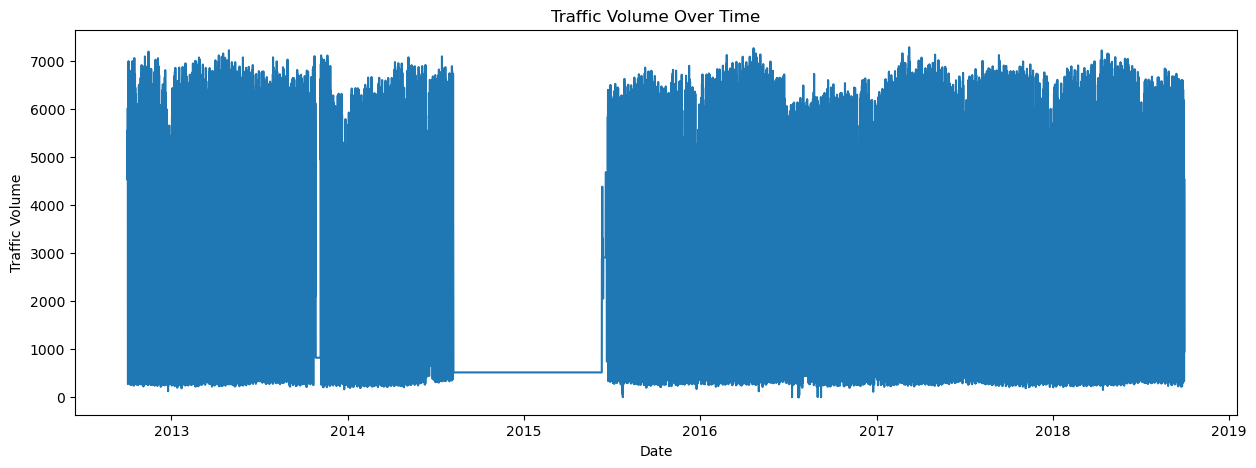

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df_ts_filled["date_time"], df_ts_filled["traffic_volume"])
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume Over Time")
plt.show()

### 2.2 Seasonality Analysis

Does traffic volume repeat in predictable cycles?
check:

Hour-of-day seasonality (daily pattern)

Day-of-week seasonality (weekly pattern)

In [38]:
# Create Time-Based Features
df_eda = df_ts_filled.copy()

df_eda["hour"] = df_eda["date_time"].dt.hour
df_eda["day_of_week"] = df_eda["date_time"].dt.dayofweek

In [39]:
# Average Traffic by Hour of Day
hourly_avg = (
    df_eda
    .groupby("hour")["traffic_volume"]
    .mean()
)

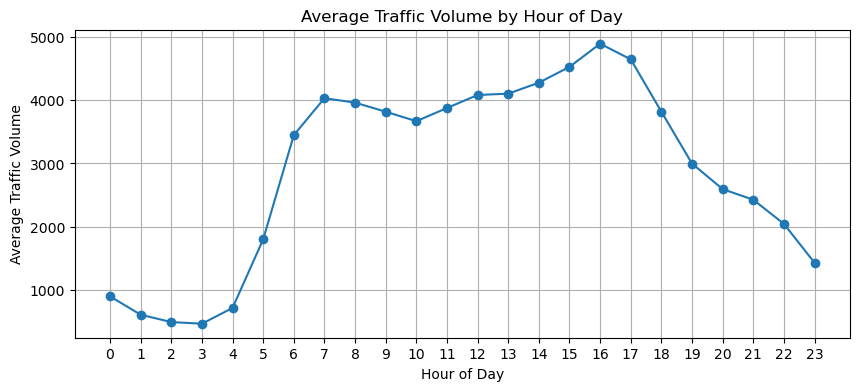

In [40]:
plt.figure(figsize=(10, 4))
plt.plot(hourly_avg.index, hourly_avg.values, marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("Average Traffic Volume")
plt.title("Average Traffic Volume by Hour of Day")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

In [41]:
# Average Traffic by Day of Week
weekday_avg = (
    df_eda
    .groupby("day_of_week")["traffic_volume"]
    .mean()
)

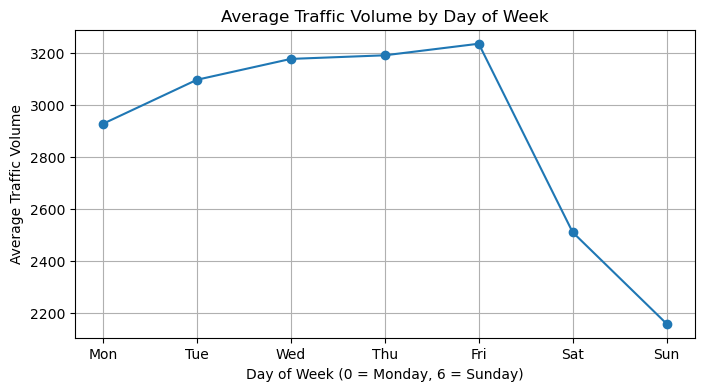

In [42]:
plt.figure(figsize=(8, 4))
plt.plot(weekday_avg.index, weekday_avg.values, marker="o")
plt.xlabel("Day of Week (0 = Monday, 6 = Sunday)")
plt.ylabel("Average Traffic Volume")
plt.title("Average Traffic Volume by Day of Week")
plt.xticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.grid(True)
plt.show()

### 2.3 Weather and Holiday Effects
Time-based seasonality explains when traffic changes

Weather and holidays explain why traffic deviates from normal patterns

If there are meaningful effects here, justify adding exogenous variables in SARIMAX.

In [43]:
# Traffic Volume by Weather Condition
weather_avg = (
    df_eda
    .groupby("weather_main")["traffic_volume"]
    .mean()
    .sort_values()
)

weather_avg

weather_main
Squall           420.000000
Clear           2207.809671
Fog             2662.646659
Mist            2834.257206
Thunderstorm    3155.238462
Snow            3217.774543
Drizzle         3369.297521
Rain            3456.217984
Haze            3545.823656
Clouds          3608.101046
Smoke           4443.000000
Name: traffic_volume, dtype: float64

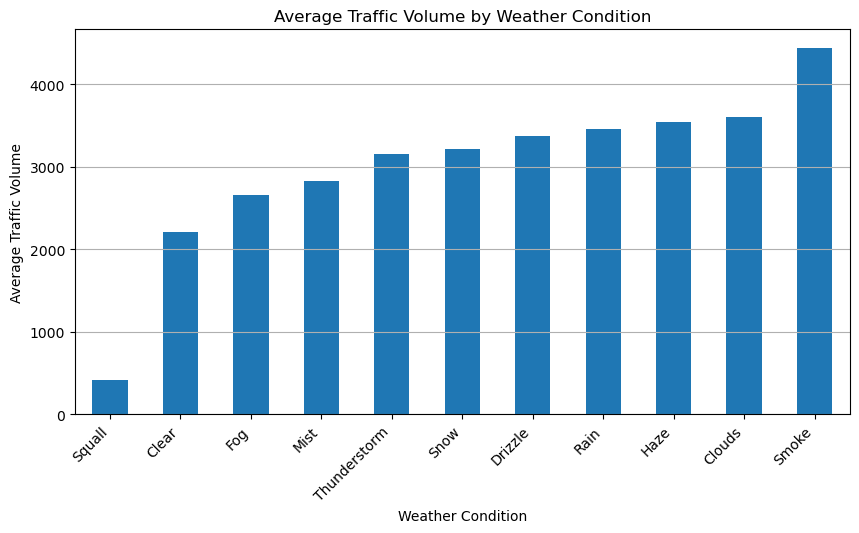

In [44]:
plt.figure(figsize=(10, 5))
weather_avg.plot(kind="bar")
plt.xlabel("Weather Condition")
plt.ylabel("Average Traffic Volume")
plt.title("Average Traffic Volume by Weather Condition")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.show()

In [45]:
# Traffic Volume on Holidays vs Non-Holidays
holiday_avg = (
    df_eda
    .groupby("holiday")["traffic_volume"]
    .mean()
    .sort_values()
)

holiday_avg.head(10)

holiday
Columbus Day                  529.428571
Martin Luther King Jr Day     592.666667
State Fair                    634.800000
Washingtons Birthday          635.200000
Veterans Day                  691.400000
Christmas Day                 846.600000
Thanksgiving Day              933.500000
Labor Day                    1013.200000
Independence Day             1076.000000
Memorial Day                 1107.600000
Name: traffic_volume, dtype: float64

In [46]:
df_eda["is_holiday"] = df_eda["holiday"] != "None"

holiday_binary_avg = (
    df_eda
    .groupby("is_holiday")["traffic_volume"]
    .mean()
)

holiday_binary_avg

is_holiday
False    2902.956663
True      852.357143
Name: traffic_volume, dtype: float64

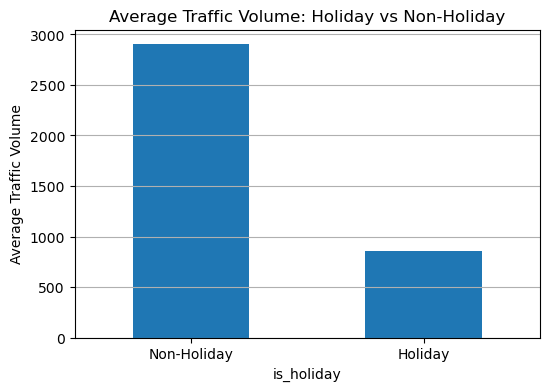

In [47]:
plt.figure(figsize=(6, 4))
holiday_binary_avg.plot(kind="bar")
plt.xticks([0, 1], ["Non-Holiday", "Holiday"], rotation=0)
plt.ylabel("Average Traffic Volume")
plt.title("Average Traffic Volume: Holiday vs Non-Holiday")
plt.grid(axis="y")
plt.show()

### 2.4 Correlation Analysis

To further explore relationships between numeric features and traffic volume, a correlation analysis was conducted.  
This analysis provides a high-level view of linear associations between variables, complementing the time-based and seasonal analyses performed earlier.

In [48]:
# Select Numeric Features
numeric_features = [
    "traffic_volume",
    "temp",
    "rain_1h",
    "snow_1h",
    "clouds_all"
]

df_corr = df_eda[numeric_features]

In [49]:
# Correlation Matrix
corr_matrix = df_corr.corr()
corr_matrix

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
traffic_volume,1.000000,-0.023844,0.005703,0.006884,0.250042
temp,-0.023844,1.000000,0.007120,-0.019023,-0.205501
rain_1h,0.005703,0.007120,1.000000,-0.000063,0.005449
snow_1h,0.006884,-0.019023,-0.000063,1.000000,0.029857
clouds_all,0.250042,-0.205501,0.005449,0.029857,1.000000


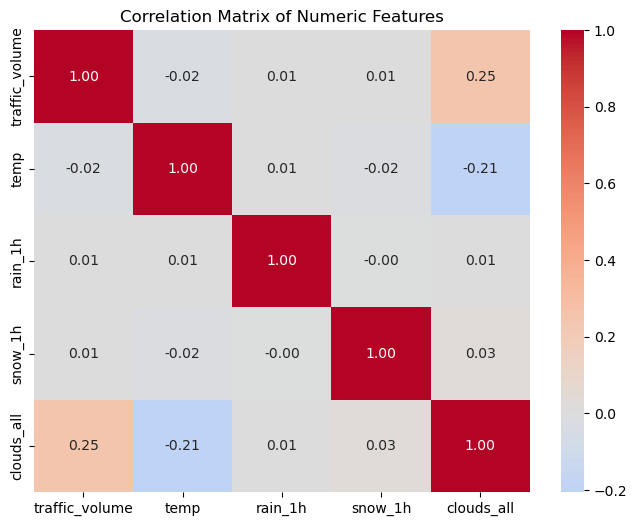

In [50]:
# Correlation Heatmap
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

### 2.5 Summary of EDA Findings and Modeling Implications

Exploratory data analysis revealed several key characteristics of the traffic volume time series that inform model selection and preprocessing decisions.

**Temporal structure and seasonality:**  
Traffic volume exhibits strong and consistent intraday and weekly seasonality. Average traffic levels vary significantly by hour of day, with clear peaks during typical commuting periods, and by day of week, with higher volumes on weekdays compared to weekends. These recurring temporal patterns indicate that seasonal time-series models are well-suited for this dataset.

**Stability and variability:**  
While traffic volume fluctuates substantially at an hourly level, the overall structure of the series remains stable over time. This suggests that the underlying traffic-generating process is relatively consistent, supporting the effectiveness of simple, seasonality-driven forecasting models.

**Weather effects:**  
Weather conditions show meaningful associations with traffic volume. Adverse weather events such as snow and heavy precipitation are associated with lower average traffic levels, while clearer conditions correspond to higher volumes. Although linear correlations are generally modest, these effects are systematic and context-dependent, suggesting that weather variables may provide additional explanatory power when included as exogenous inputs.

**Holiday effects:**  
Traffic volume differs noticeably between holidays and non-holiday periods, with holidays generally exhibiting reduced traffic. These deviations are not fully captured by weekly seasonality alone, indicating that holidays function as special events influencing traffic patterns.

**Modeling implications:**  
Based on these findings, a progressive modeling strategy is appropriate. A simple seasonal baseline model will be used to establish a performance benchmark. A SARIMA model will then be employed to capture the strong temporal and seasonal dependencies observed in the data. Finally, a SARIMAX model will be explored to incorporate weather and holiday variables as exogenous regressors, allowing the model to account for deviations driven by external factors.

In [51]:
df_ts_filled.to_csv("traffic_volume_cleaned_hourly.csv", index=False)

In [52]:
import os
os.listdir()

['.ipynb_checkpoints',
 'Capstone 3-Project Ideas.docx',
 'Capstone Three-Data Wrangling and EDA.ipynb',
 'Capstone Three-Pre-processing Work and Model-Copy1.ipynb',
 'Capstone Three-Pre-processing Work and Model.ipynb',
 'Metro_Interstate_Traffic_Volume.csv',
 'Problem Statement Worksheet – Metro Interstate Traffic Volume Project.pptx',
 'Problem Statement Worksheet – Metro Interstate Traffic Volume Project.pptx.pdf',
 'traffic_volume_cleaned_hourly.csv']